# 해야할 일
1. map_name이 없는 6117개의 row. 지우기. 왜냐면 이건 normal user data인데 cheater data가 훨씬 적기때문에 저거 없어져도 상관없음. 
        '''사녹 65명
        비켄디 99명
        파라모 65명
        카라킨 65명
        헤이븐 30명'''



1. rank, total rank 묶어서 percentile로 하는게 더 좋겠다.
    * percentile = rank/total_rank
1. mapping: tpp=1, fpp=0
1. mapping: queue_size=3
    * 클래스가 1, 2, 4 밖에 없는데 consistancy를 위해 4를 3으로
1. 필요없는 column 없애기 - type, match_type


전처리

1. 최근 4일간 x=started at, y=kills, groupby nickname 으로 histogram 겹치게 그리기.
    * None value 인것들 찾아서 평균값 혹은 표준편차에서 랜덤값 주기

# 배틀그라운드 핵 사용 유저 분석 및 ML을 통한 핵 사용 예측

# Table of Content
* 데이터 불러오기
* 데이터 클리닝
* EDA
    1. 
    1.

    
  
* 전처리


1. 데이터 분류
2. 연관성 찾기. 입력값과 예측값이 얼마나 연관있는지 파악
3. 넣을 자료 정제. 전처리.
4. 빠진값 넣어주기
5. 스케일링..?
6. 모델 만들기

In [95]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext

# Start Spark Session
spark = SparkSession.builder \
    .master('local[4]') \
    .config("spark.driver.memory", "2g") \
    .config("spark.executor.memory", "2g") \
    .config("spark.executor.cores", "4") \
    .config("spark.cores.max", "4") \
    .appName('pubg_data') \
    .getOrCreate()
sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

# Readme 에 PUBG 그래픽 넣고 설명 좀 달고 시작하는거 잊지말자

## 데이터 불러오기

핵 사용 유저 아이디 3222개는 https://pubg.game.daum.net 에서 가져왔으며,  
2020년 2월1일부터 29일까지 핵 사용으로 인해 정지당한 계정입니다.  
보통 유저 아이디 3533개는 https://www.kaggle.com/leonardokarl/pubg-statisctic 에서 가져왔습니다.  
이후 위 소스에서 가져온 아이디의 게임정보를 https://pubg.op.gg 에서 스크레이핑 했습니다.

자세한 사항은 다음 리포를 참고해 주세요:
https://github.com/alpacapetter/pubg-cheater-behavior-analysis/blob/main/user_data_scraper.py

In [36]:
# Spark.SQL 사용하여 필요 데이터 추출
df_normal = spark.sql(
                        "SELECT *\
                        FROM parquet.`./normal_user_data.parquet`\
                        WHERE type = 'official'\
                        AND (mode = 'tpp' OR mode = 'fpp')"
                        )
df_cheater = spark.sql(
                        "SELECT *\
                        FROM parquet.`./cheater_data.parquet`\
                        WHERE started_at < '2020-03-01'\
                            AND started_at >'2017-12-20'\
                            AND type = 'official'\
                            AND (mode = 'tpp' OR mode = 'fpp')"
                        )

# 간단히 데이터 확인을 위해 Spark DataFrame을 Pandas로 변환
df_normal = df_normal.toPandas()
df_cheater = df_cheater.toPandas()

### 위 SQL 쿼리는 다음과 같은 requirement 에 의해 만들어졌습니다:
1. started_at 이 2020-03-01 이전 데이터만 사용  
    * 2020년 2월에 정지 당했던 유저 데이터중 1년 후 정지가 풀린 후의 게임을 배제합니다.
1. type 이 official인것만 사용  
    * type 이 event인 데스매치의 경우 kill수가 배틀로얄과 다르기 때문에 배제합니다.
1. mode 중 fpp와 tpp만 사용  
    * 282 row의 empty mode 를 배제합니다. 

새로운 column "class"을 만들어서 cheater=1, normal=0 로 맵핑한 후 하나의 df 로 합쳐줍니다.

In [37]:
df_cheater['class'] = 1
df_normal['class'] = 0
df = pd.concat([df_cheater, df_normal])

<br>

## 데이터 클리닝

데이터를 확인합니다.

In [38]:
df.head()

,type,mode,started_at,total_rank,queue_size,map_name,match_type,rank,heals,boosts,...,kills,assists,kill_steaks,headshot_kills,longest_kill,damage_dealt,knock_downs,revives,nickname,class
0,official,tpp,2020-02-22 03:11:00,27,4,Savage_Main,None,27,0,0,...,0,0,0,0,0,0,0,0,jjunbang,1
1,official,tpp,2020-02-22 02:49:52,29,4,Baltic_Main,None,2,10,5,...,16,2,3,5,369,1624,12,1,jjunbang,1
2,official,tpp,2020-02-22 02:35:05,29,4,Savage_Main,None,1,3,6,...,12,0,2,4,154,1933,14,0,jjunbang,1
3,official,tpp,2020-02-22 02:33:14,33,4,Baltic_Main,None,18,6,4,...,8,0,2,1,28,833,6,0,jjunbang,1
4,official,tpp,2020-02-22 02:28:59,29,4,Savage_Main,None,25,1,0,...,1,0,1,0,2,154,1,0,jjunbang,1


스키마를 확인합니다.  
데이터를 스크레이핑할때부터 이미 스키마를 정한 후 parquet 파일로 저장해줬기에 data type이 올바름을 볼 수 있습니다.

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 456250 entries, 0 to 236559
Data columns (total 22 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   type            456250 non-null  object        
 1   mode            456250 non-null  object        
 2   started_at      456250 non-null  datetime64[ns]
 3   total_rank      456250 non-null  int32         
 4   queue_size      456250 non-null  int32         
 5   map_name        402222 non-null  object        
 6   match_type      59121 non-null   object        
 7   rank            456250 non-null  int32         
 8   heals           456250 non-null  int32         
 9   boosts          456250 non-null  int32         
 10  death_type      456250 non-null  object        
 11  time_survived   456250 non-null  int32         
 12  kills           456250 non-null  int32         
 13  assists         456250 non-null  int32         
 14  kill_steaks     456250 non-null  int

새로운 column "class"을 만들어서 mapping: cheater=1, normal=0 해준다음 df을 합쳐줍니다.


In [40]:
def bar_chart(col):
    cheater = df[df['class']==1][col].value_counts()
    normal = df[df['class']==0][col].value_counts()
    df_chart = pd.DataFrame([cheater,normal])
    df_chart.index = ['Cheater','Normal']
    df_chart.plot(kind='bar',stacked=True, figsize=(10,5))

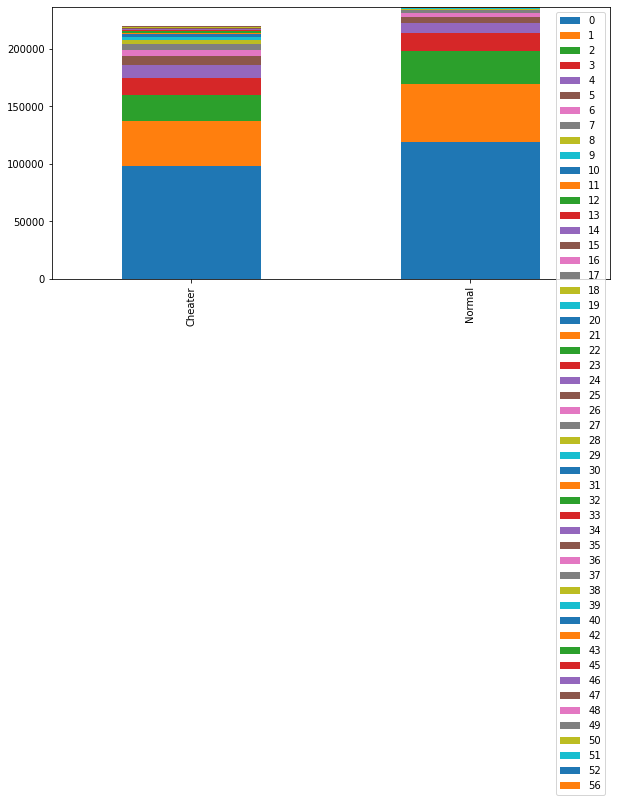

In [41]:
bar_chart('kills')

Cheater와 Normal의 kill 수가 크게 차이나지 않는걸 볼 수 있습니다. 이유는 플레이어당 약 100개의 최근 게임데이터를 가져왔기 때문에 cheater 유저라도 핵을 사용하지 않은 게임의 수가 훨씬 많기 때문입니다. 최대한 실제 핵을 사용한 게임만을 간추려보겠습니다.

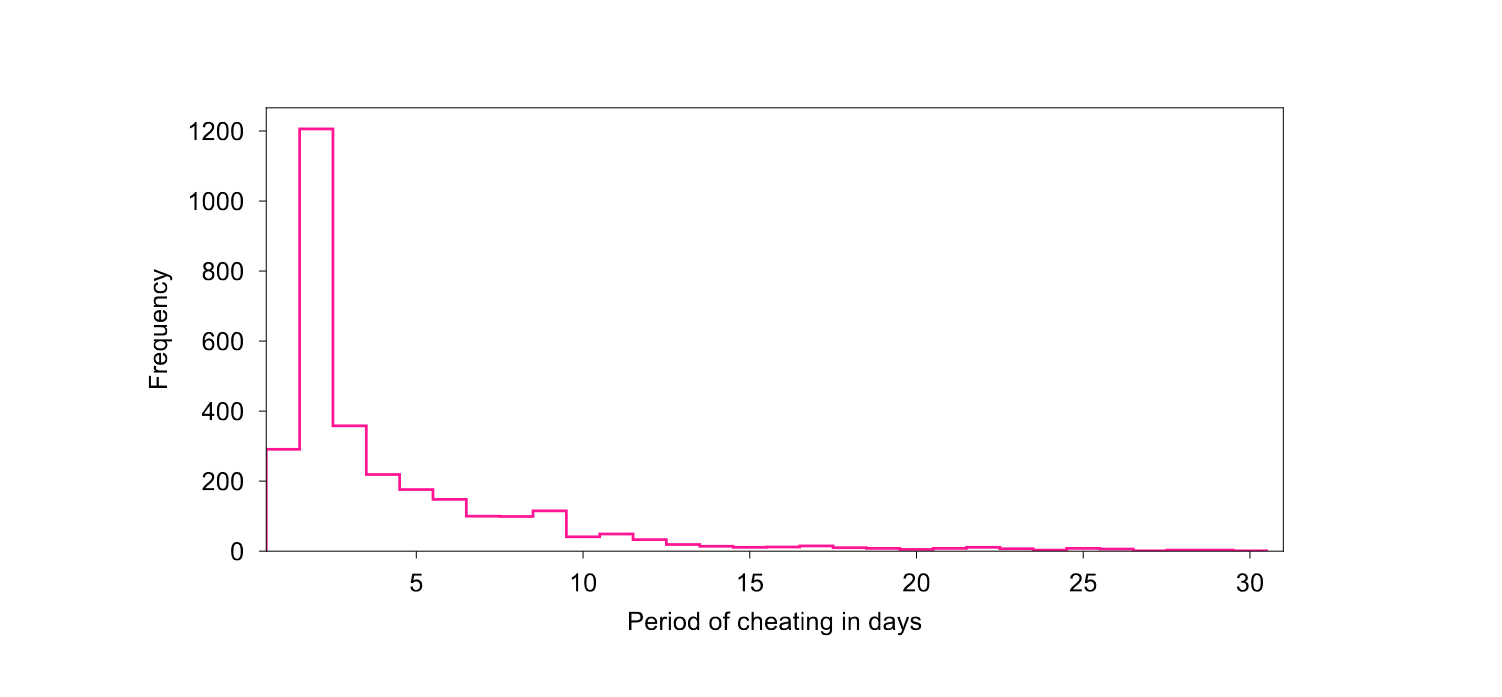

출처: *[Large-scale network analysis reveals cheating spreads throughvictimization and observationJi Eun Kim and Milena TsvetkovaDepartment of Methodology, London School of Economics and Political Science, London WC2A2AE, United Kingdom]*

위 그림은 핵 사용유저가 몇일동안 핵을 사용하는지에 대한 그래프 입니다.  
핵을 사용한 대부분의 유저가 2일만에 정지를 당하는걸 볼 수 있습니다.  

Classificaiton 모델을 사용하기 위해 핵 사용 유저가 실제 핵을 사용한 게임만을 간추리도록, 최근 3일간 데이터만 사용하겠습니다.  
(나중엔 KNN & DTW를 사용한 Timeseries Classification 모델과 비교할 계획입니다.)

In [153]:
df_cheater = df.loc[df['class'] == 1]
df_cheater = df_cheater.sort_values(by=['nickname', 'started_at'], ascending=False)
cheater_nickname_list = df_cheater['nickname'].unique()
df_new_cheater = pd.DataFrame()

for name in cheater_nickname_list:
    df_nickname = df_cheater.loc[df_cheater['nickname'] == name]
    start_date = df_nickname.iloc[0]['started_at']
    end_date = start_date - datetime.timedelta(days=2)
    mask = (df_nickname['started_at'] <= start_date) & (df_nickname['started_at'] >= end_date)
    df_nickname = df_nickname.loc[mask]
    if df_new_cheater.empty:
        df_new_cheater = df_nickname.loc[mask]
    else:
        df_new_cheater = df_new_cheater.append(df_nickname)

df 의 cheater 데이터를 위 실제 핵 사용 게임 데이터로 교체합니다.

In [188]:
df = df[df['class'].isin([0])]
df = df.append(df_new_cheater)

In [189]:
df

,type,mode,started_at,total_rank,queue_size,map_name,match_type,rank,heals,boosts,...,kills,assists,kill_steaks,headshot_kills,longest_kill,damage_dealt,knock_downs,revives,nickname,class
0,official,fpp,2021-04-20 23:53:08,29,4,Baltic_Main,official,29,0,0,...,0,0,0,0,0,0,0,0,nahstee,0
1,official,fpp,2021-04-20 23:40:39,29,4,Desert_Main,official,20,4,1,...,2,0,1,2,183,298,3,0,nahstee,0
2,official,fpp,2021-04-20 23:22:40,31,4,Savage_Main,official,8,1,2,...,1,0,1,0,41,59,0,0,nahstee,0
3,official,fpp,2021-04-18 00:35:12,31,4,DihorOtok_Main,official,15,0,0,...,1,0,1,0,11,181,1,0,nahstee,0
4,official,fpp,2020-11-20 12:19:12,30,4,Baltic_Main,official,14,0,1,...,0,0,0,0,0,59,0,0,nahstee,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2580,official,tpp,2020-02-24 17:13:44,26,4,Savage_Main,None,1,0,4,...,6,1,2,4,112,817,3,1,0-TTukBaeGi-0,1
2581,official,tpp,2020-02-24 16:48:40,26,4,Savage_Main,None,1,0,0,...,0,0,0,0,0,0,0,0,0-TTukBaeGi-0,1
2582,official,tpp,2020-02-24 16:25:52,28,4,Savage_Main,None,1,4,5,...,8,1,3,0,237,1064,7,0,0-TTukBaeGi-0,1
2583,official,tpp,2020-02-24 16:00:56,26,4,Savage_Main,None,1,1,5,...,12,1,4,3,326,1511,10,0,0-TTukBaeGi-0,1


In [192]:
df.isna().sum()

type                   0
mode                   0
started_at             0
total_rank             0
queue_size             0
map_name           44908
match_type        248115
rank                   0
heals                  0
boosts                 0
death_type             0
time_survived          0
kills                  0
assists                0
kill_steaks            0
headshot_kills         0
longest_kill           0
damage_dealt           0
knock_downs            0
revives                0
nickname               0
class                  0
dtype: int64

In [11]:
df.groupby(['map_name'], as_index=False).count()

,map_name,type,mode,started_at,total_rank,queue_size,match_type,rank,heals,boosts,...,kills,assists,kill_steaks,headshot_kills,longest_kill,damage_dealt,knock_downs,revives,nickname,class
0,Baltic_Main,59927,59927,59927,59927,59927,17007,59927,59927,59927,...,59927,59927,59927,59927,59927,59927,59927,59927,59927,59927
1,Chimera_Main,4551,4551,4551,4551,4551,4551,4551,4551,4551,...,4551,4551,4551,4551,4551,4551,4551,4551,4551,4551
2,Desert_Main,37198,37198,37198,37198,37198,10679,37198,37198,37198,...,37198,37198,37198,37198,37198,37198,37198,37198,37198,37198
3,DihorOtok_Main,26395,26395,26395,26395,26395,7977,26395,26395,26395,...,26395,26395,26395,26395,26395,26395,26395,26395,26395,26395
4,Erangel_Main,27138,27138,27138,27138,27138,0,27138,27138,27138,...,27138,27138,27138,27138,27138,27138,27138,27138,27138,27138
5,Heaven_Main,1418,1418,1418,1418,1418,1418,1418,1418,1418,...,1418,1418,1418,1418,1418,1418,1418,1418,1418,1418
6,Range_Main,148,148,148,148,148,148,148,148,148,...,148,148,148,148,148,148,148,148,148,148
7,Savage_Main,192510,192510,192510,192510,192510,12002,192510,192510,192510,...,192510,192510,192510,192510,192510,192510,192510,192510,192510,192510
8,Summerland_Main,52937,52937,52937,52937,52937,5339,52937,52937,52937,...,52937,52937,52937,52937,52937,52937,52937,52937,52937,52937


In [21]:
df_normal.groupby(['mode']).count()

DataFrame[mode: string, count: bigint]

In [193]:
df['match_type'].unique()

array(['official', None, 'competitive', 'training'], dtype=object)

In [212]:
hi = df.loc[df['match_type']=='training']
#이거 없애버리고 None None은 official 이니까 match_type column 을 나중에 아예 없애버려야 함

In [215]:
hi = df.loc[df['match_type'].isna()]
hi.describe()

,total_rank,queue_size,rank,heals,boosts,time_survived,kills,assists,kill_steaks,headshot_kills,longest_kill,damage_dealt,knock_downs,revives,class
count,248115.000000,248115.000000,248115.000000,248115.000000,248115.000000,248115.000000,248115.000000,248115.000000,248115.000000,248115.000000,248115.000000,248115.000000,248115.000000,248115.000000,248115.000000
mean,40.951631,3.039389,19.258618,1.695444,1.729916,732.996066,1.741596,0.334043,0.774983,0.455224,41.515700,233.161353,1.257864,0.179405,0.284852
std,22.063753,1.178055,17.538265,3.016884,2.355161,525.260580,2.879044,0.723147,0.884800,1.175146,76.197899,324.992970,2.172153,0.484828,0.451345
min,1.000000,1.000000,1.000000,0.000000,0.000000,-1935.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,2.000000,6.000000,0.000000,0.000000,249.000000,0.000000,0.000000,0.000000,0.000000,0.000000,27.000000,0.000000,0.000000,0.000000
50%,30.000000,4.000000,15.000000,0.000000,1.000000,625.000000,1.000000,0.000000,1.000000,0.000000,4.000000,121.000000,0.000000,0.000000,0.000000
75%,48.000000,4.000000,26.000000,2.000000,3.000000,1159.000000,2.000000,0.000000,1.000000,1.000000,50.000000,299.000000,2.000000,0.000000,1.000000
max,101.000000,4.000000,100.000000,66.000000,26.000000,2223.000000,56.000000,10.000000,45.000000,52.000000,4530.000000,5361.000000,40.000000,12.000000,1.000000
